In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import xarray as xr
path = "/Volumes/opto_loc/Data/ACR_39/swi-bl-NNXo.nc"
da = xr.open_dataarray(path)

/tmp/ipykernel_924079/1504366668.py:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  da = xr.open_dataarray(path)


In [2]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import acr
import warnings
import pingouin as pg
from scipy.stats import shapiro, normaltest
import os
from pathlib import Path

import pingouin as pg

warnings.filterwarnings('ignore')
probe_ord = ['NNXr', 'NNXo']
#hue_ord = [NNXR_GRAY, MAIN_COLOR]
from kdephys.utils.main import td

#--------------------------------- Import Publication Functions ---------------------------------#
pub_utils = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py', 'pub_utils')
from pub_utils import *
data_agg = acr.utils.import_publication_functions('/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py', 'data_agg')
from data_agg import *

#--------------------------------- Plotting Setup ---------------------------------#
import pubplots as pp
style_path = '/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/plot_styles/acrvec_labels.mplstyle'
plt.rcdefaults()
plt.style.use(style_path)
from cmcrameri import cm as scm

In [3]:
import numpy as np
import xarray as xr

def fast_coarsen_sum(da: xr.DataArray, factor: int, dim: str = 'datetime') -> xr.DataArray:
    """
    Fast alternative to da.coarsen(datetime=factor, boundary='trim').sum()
    Uses numpy reshape for ~10-50x speedup.
    """
    axis = da.dims.index(dim)
    data = da.values
    
    # Trim to make divisible by factor
    n = data.shape[axis]
    n_trim = n - (n % factor)
    
    # Slice to trimmed length along the right axis
    slices = [slice(None)] * data.ndim
    slices[axis] = slice(0, n_trim)
    data = data[tuple(slices)]
    
    # Reshape and sum
    new_shape = list(data.shape)
    new_shape[axis] = n_trim // factor
    new_shape.insert(axis + 1, factor)
    reshaped = data.reshape(new_shape)
    #summed = reshaped.astype(np.uint8).sum(axis=axis + 1)  # if you expect values > 255
    summed = reshaped.sum(axis=axis + 1)
    
    # Build new coordinates (take every factor-th coord, starting from the first)
    new_coords = {k: v for k, v in da.coords.items() if dim not in da[k].dims}
    new_coords[dim] = da.coords[dim].values[:n_trim:factor]
    
    return xr.DataArray(summed, dims=da.dims, coords=new_coords)

In [4]:
nbroot = os.path.join(PAPER_FIGURE_ROOT, 'response_to_review', 'fr_comps')
Path(nbroot).mkdir(parents=True, exist_ok=True)

In [5]:
from acr.utils import HALO_GREEN, NNXR_GRAY

MAIN_EXP = 'swi'
SUBJECT_TYPE = 'acr'
MAIN_COLOR = ACR_BLUE
subjects, exps = get_subject_list(type=SUBJECT_TYPE, exp=MAIN_EXP)
subjects, exps = remove_subject('ACR_16', subjects, exps)

In [6]:
full_hyps = {}
hyp_dicts = {}
for subject, exp in zip(subjects, exps):
    full_hyps[subject] = acr.io.load_hypno_full_exp(subject, exp)
    hyp_dicts[subject] = acr.hypnogram_utils.create_hyp_dict_fast(subject, exp, true_stim=False, duration='3600s')

In [7]:
stim_times = {}
for subject, exp in zip(subjects, exps):
    stim_times[subject] = acr.hypnogram_utils.get_true_stim_hyp(subject, exp)

In [8]:
sc = {}
for subject, exp in zip(subjects, exps):
    sc[subject] = load_binned_spikes(subject, exp)

In [9]:
scc = {}
for subject in subjects:
    scc[subject] = {}
    for probe in ['NNXo']:
        scc[subject][probe] = fast_coarsen_sum(sc[subject][probe], 5)

# Example Rasters Across all spikes on all all animals

In [10]:
scd = {}
scd['ACR_18'] = [3, 4, 5, 10]


In [11]:
probe = 'NNXo'
stim_counts = {}
stim_data = {}
for subject, exp in zip(subjects, exps):
    stim_counts[subject] = []
    stim_starts, stim_ends = acr.stim.get_individual_pulse_times(subject, exp, pandas=True)
    ss = stim_starts[1800:2700]
    se = stim_ends[1800:2700]
    for i in np.arange(0, len(ss), 3):
        t1 = ss[i]
        t2 = t1+td(1000, 'ms')
        data = scc[subject][probe].sel(datetime=slice(t1, t2))
        if data.shape != (16, 200):
            print(data.shape)
            data = data[:, :200]
        stim_counts[subject].append(data.values)
    stim_data[subject] = np.stack(stim_counts[subject]) # shape trials x channel x time

(16, 201)


In [12]:
dat = np.stack([stim_data[subject] for subject in subjects]) # shape subject x trials x channel x time

In [13]:
dat_all_trials = np.reshape(dat, (len(subjects)*300, 16, 200)) # shape trials x channel x time (across all subjects)

In [14]:
chan_sum = np.sum(dat.sum(axis=0), axis=1) # shape trials x time

In [15]:
trial_avg = dat_all_trials.mean(axis=0) # shape channel x time

In [16]:
xt = [0, 50, 100, 150, 200]
xtl = [(x*5)/1000 for x in xt]

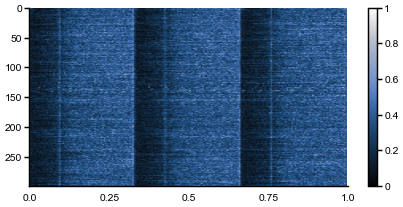

In [34]:
figname = 'ACR_OFF_example_100ms_all_subjects'
figpath = os.path.join(nbroot, f'{figname}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(3, 1.5))
    im = ax.imshow(chan_sum, aspect='auto', cmap=scm.oslo, vmin=0, vmax=120)
    cbar = f.colorbar(im, ax=ax)
    cbar.set_ticks([0, 24, 48, 72, 96, 120])
    cbar.set_ticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticks(xt)
    ax.set_xticklabels(xtl)
    plt.show()
    f.savefig(figpath, dpi=600, bbox_inches='tight', transparent=True)

# DEPTH

In [18]:
def get_supra_infra_chans(subject, probe):
    sib = acr.info_pipeline.load_sub_infra_borders()
    chans = np.arange(1, 17)
    lb = sib[subject][probe]['gran_lower']
    ub = sib[subject][probe]['gran_upper']
    if lb == ub:
        supra_chans = chans[:ub]
        infra_chans = chans[ub:]
        return supra_chans, infra_chans
    else:
        supra_chans = chans[:ub-1]
        infra_chans = chans[lb:]
        return supra_chans, infra_chans

In [19]:
probe = 'NNXo'
stim_counts = {}
stim_data = {}
for subject, exp in zip(subjects, exps):
    print(subject)
    stim_counts[subject] = []
    sub_data = sc[subject][probe]
    if subject in scd:
        sub_data = sub_data.sel(channel=np.array([c for c in sub_data.channel if c not in scd[subject]]))
    stim_starts, stim_ends = acr.stim.get_individual_pulse_times(subject, exp, pandas=True)
    ps_hyp = hyp_dicts[subject]['early_sd']
    ps_sums = []
    ps_dur = ps_hyp['duration'].sum().total_seconds()
    for bout in ps_hyp.itertuples():
        pdat = sub_data.sel(datetime=slice(bout.start_time, bout.end_time))
        ps_sums.append(pdat.values.sum(axis=(0, 1)))
    ps_sum = np.sum(ps_sums)
    ps_rate = ps_sum/ps_dur
    
    for i in np.arange(0, 2700):
        s = stim_starts[i]
        e = stim_ends[i]
        data = sub_data.sel(datetime=slice(s, e))
        stim_sum = data.values.sum(axis=(0, 1))
        stim_rate = stim_sum/(e-s).total_seconds()
        stim_rate_rel = stim_rate/ps_rate
        stim_counts[subject].append(stim_rate_rel)

ACR_17
ACR_18
ACR_19
ACR_20
ACR_23
ACR_31
ACR_33
ACR_34


In [20]:
all_stims = np.concatenate([stim_counts[subject] for subject in subjects])

In [21]:
probe = 'NNXo'
sc_ints = {}
stim_data = {}
for subject, exp in zip(subjects, exps):
    print(subject)
    sc_ints[subject] = []
    stim_starts, stim_ends = acr.stim.get_individual_pulse_times(subject, exp, pandas=True)
    sub_data = sc[subject][probe]
    if subject in scd:
        sub_data = sub_data.sel(channel=np.array([c for c in sub_data.channel if c not in scd[subject]]))
    ps_hyp = hyp_dicts[subject]['early_sd']
    ps_sums = []
    ps_dur = ps_hyp['duration'].sum().total_seconds()
    for bout in ps_hyp.itertuples():
        pdat = sub_data.sel(datetime=slice(bout.start_time, bout.end_time))
        ps_sums.append(pdat.values.sum(axis=(0, 1)))
    ps_sum = np.sum(ps_sums)
    ps_rate = ps_sum/ps_dur
    
    for i in np.arange(0, 2700):
        s = stim_ends[i]
        e = stim_starts[i+1]
        if (e-s).total_seconds() > 1:
            e = s+td(250, 'ms')
        data = sub_data.sel(datetime=slice(s, e))
        stim_sum = data.values.sum(axis=(0, 1))
        stim_rate = stim_sum/(e-s).total_seconds()
        stim_rate_rel = stim_rate/ps_rate
        sc_ints[subject].append(stim_rate_rel)

ACR_17
ACR_18
ACR_19
ACR_20
ACR_23
ACR_31
ACR_33
ACR_34


In [22]:
all_ints = np.concatenate([sc_ints[subject] for subject in subjects])

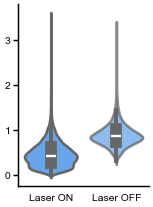

In [23]:
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.2, 1.5))
    sns.violinplot([all_stims, all_ints], palette=[ACR_BLUE, ACR_BLUE], ax=ax, alpha=1)
    for i, violin in enumerate(ax.collections):
        if i == 1:  # right violin
            violin.set_alpha(0.75)
    #ax.set_ylim(-0.1, 1.5)
    ax.set_xticklabels(['Laser ON', 'Laser OFF'])
    plt.show()

1.3439161190159128


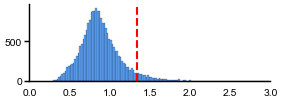

In [24]:
figname = 'histogram_ACR_OFF_interval_rates'
figpath = os.path.join(nbroot, f'{figname}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(2, .8))
    sns.histplot(all_ints, ax=ax, color=ACR_BLUE, alpha=0.95)
    print(np.percentile(all_ints, 95))
    ax.axvline(np.percentile(all_ints, 95), color='red', linestyle='--')
    ax.set_xlim(0, 3)
    ax.set_ylabel(None)
    plt.show()
    f.savefig(figpath, dpi=600, bbox_inches='tight', transparent=True)

0.9654310428985972


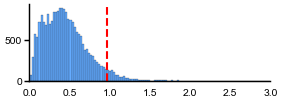

In [25]:
figname = 'histogram_ACR_OFF_stim_rates'
figpath = os.path.join(nbroot, f'{figname}.svg')
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(2, .8))
    sns.histplot(all_stims, ax=ax, color=ACR_BLUE, alpha=0.9)
    print(np.percentile(all_stims, 95))
    ax.axvline(np.percentile(all_stims, 95), color='red', linestyle='--')
    ax.set_ylabel(None)
    ax.set_xlim(0, 3)
    plt.show()

    f.savefig(figpath, dpi=600, bbox_inches='tight', transparent=True)

# supra v infra

In [26]:
for subject in subjects:
    supra, infra = get_supra_infra_chans(subject, 'NNXo')
    print(supra, infra)

[1 2 3] [ 7  8  9 10 11 12 13 14 15 16]
[1 2 3 4 5 6 7] [ 8  9 10 11 12 13 14 15 16]
[1 2 3 4 5 6 7] [ 8  9 10 11 12 13 14 15 16]
[1 2 3 4 5 6] [ 7  8  9 10 11 12 13 14 15 16]
[1 2 3 4] [ 9 10 11 12 13 14 15 16]
[1 2 3 4 5] [10 11 12 13 14 15 16]
[1 2 3 4 5] [ 6  7  8  9 10 11 12 13 14 15 16]
[1 2 3 4 5 6] [ 7  8  9 10 11 12 13 14 15 16]


In [27]:
probe = 'NNXo'
supra_rates = {}
stim_data = {}
for subject, exp in zip(subjects, exps):
    print(subject)
    supra_rates[subject] = []
    sup, infr = get_supra_infra_chans(subject, 'NNXo')
    if subject in scd:
        sup = np.array([s for s in sup if s not in scd[subject]])
        infr = np.array([i for i in infr if i not in scd[subject]])
    sup = sup-1
    infr = infr-1
    stim_starts, stim_ends = acr.stim.get_individual_pulse_times(subject, exp, pandas=True)
    ps_hyp = hyp_dicts[subject]['early_sd']
    ps_sums = []
    ps_dur = ps_hyp['duration'].sum().total_seconds()
    for bout in ps_hyp.itertuples():
        pdat = sc[subject][probe].sel(datetime=slice(bout.start_time, bout.end_time), channel=sup)
        ps_sums.append(pdat.values.sum(axis=(0, 1)))
    ps_sum = np.sum(ps_sums)
    ps_rate = ps_sum/ps_dur
    
    for i in np.arange(0, 2700):
        s = stim_starts[i]
        e = stim_ends[i]
        data = sc[subject][probe].sel(datetime=slice(s, e), channel=sup)
        stim_sum = data.values.sum(axis=(0, 1))
        stim_rate = stim_sum/(e-s).total_seconds()
        stim_rate_rel = stim_rate/ps_rate
        supra_rates[subject].append(stim_rate_rel)

ACR_17
ACR_18
ACR_19
ACR_20
ACR_23
ACR_31
ACR_33
ACR_34


In [28]:
probe = 'NNXo'
infra_rates = {}
stim_data = {}
for subject, exp in zip(subjects, exps):
    print(subject)
    infra_rates[subject] = []
    sup, infr = get_supra_infra_chans(subject, 'NNXo')
    if subject in scd:
        sup = np.array([s for s in sup if s not in scd[subject]])
        infr = np.array([i for i in infr if i not in scd[subject]])
    sup = sup-1
    infr = infr-1
    stim_starts, stim_ends = acr.stim.get_individual_pulse_times(subject, exp, pandas=True)
    ps_hyp = hyp_dicts[subject]['early_sd']
    ps_sums = []
    ps_dur = ps_hyp['duration'].sum().total_seconds()
    for bout in ps_hyp.itertuples():
        pdat = sc[subject][probe].sel(datetime=slice(bout.start_time, bout.end_time), channel=infr)
        ps_sums.append(pdat.values.sum(axis=(0, 1)))
    ps_sum = np.sum(ps_sums)
    ps_rate = ps_sum/ps_dur
    
    for i in np.arange(0, 2700):
        s = stim_starts[i]
        e = stim_ends[i]
        data = sc[subject][probe].sel(datetime=slice(s, e), channel=infr)
        stim_sum = data.values.sum(axis=(0, 1))
        stim_rate = stim_sum/(e-s).total_seconds()
        stim_rate_rel = stim_rate/ps_rate
        infra_rates[subject].append(stim_rate_rel)

ACR_17
ACR_18
ACR_19
ACR_20
ACR_23
ACR_31
ACR_33
ACR_34


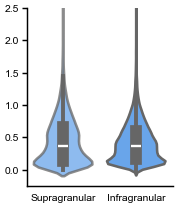

In [29]:
figname = 'ACR_supra-v-infra_during_stim_violin'
figpath = os.path.join(nbroot, f'{figname}.svg')
all_sup = np.concatenate([supra_rates[subject] for subject in subjects])
all_infra = np.concatenate([infra_rates[subject] for subject in subjects])
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.3, 1.5))
    sns.violinplot([all_sup, all_infra], palette=[ACR_BLUE, ACR_BLUE], ax=ax, alpha=1)
    for i, violin in enumerate(ax.collections):
        if i == 0:  # Left violin
            violin.set_alpha(0.75)
    ax.set_ylim(-0.25, 2.5)
    ax.set_xticklabels(['Supragranular', 'Infragranular'])
    plt.show()
    f.savefig(figpath, dpi=600, bbox_inches='tight', transparent=True)

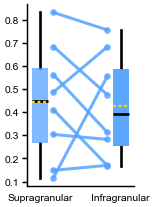

In [30]:
figname = 'ACR_supra-v-infra_during_stim--by_subject'
figpath = os.path.join(nbroot, f'{figname}.svg')
supras_by_sub = [np.mean(supra_rates[subject]) for subject in subjects]
infras_by_sub = [np.mean(infra_rates[subject]) for subject in subjects]
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.1, 1.5))
    acr.plots.gen_paired_boxplot(supras_by_sub, infras_by_sub, ax=ax, colors=[ACR_BLUE, ACR_BLUE], dot_size=50, alphas=[0.75, 0.95])
    ax.set_xticklabels(['Supragranular', 'Infragranular'])
    plt.show()
    f.savefig(figpath, dpi=600, bbox_inches='tight', transparent=True)

In [32]:
supras_by_sub = np.array(supras_by_sub)
infras_by_sub = np.array(infras_by_sub)
diffs = supras_by_sub - infras_by_sub
shap_stat, shap_p = shapiro(diffs) # test the paired differences for normality
agostino_stat, agostino_p = normaltest(diffs) # test the paired differences for normality
print(f'shapiro_p-value: {shap_p}')
print(f'd,agostino_p-value: {agostino_p}')

stats = pg.ttest(supras_by_sub, infras_by_sub, paired=True)
print(stats)
# stats = pg.wilcoxon(nnxr, nnxo)
hg = pg.compute_effsize(supras_by_sub, infras_by_sub, paired=True, eftype='hedges')
print(f'hedges g: {hg}')

#r = acr.stats.calculate_wilx_r(stats['W-val'][0], len(nnxr))
# ==== Write Stats Results ====
acr.stats.write_stats_result(
    figname, 
    'paired_ttest',
    test_statistic=stats['T'][0],
    p_value=stats['p-val'][0],
    effect_size_method='g',
    effect_size=hg,
    review=True,
)

## ===== Write Source Data =====
source_data = pd.DataFrame({'supra': supras_by_sub, 'infra': infras_by_sub, 'subject': np.arange(len(supras_by_sub))})
write_source_data(source_data, figname)

shapiro_p-value: 0.26810059097900796
d,agostino_p-value: 0.32577001737155
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.207197    7   two-sided  0.841755  [-0.18, 0.22]  0.073254  0.342   

          power  
T-test  0.05374  
hedges g: 0.06925870595694439


In [33]:
stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.207197,7,two-sided,0.841755,"[-0.18, 0.22]",0.073254,0.342,0.05374
